## Programming Assignment # 4

**Data Science Practicum**


This assignment will ask you to develop a notebook requiring various data-related activities (importing, cleaning, manipulating, merging, and aggregating)..

# Topic: Measuring Neighborhood Availability of Alcohol

Use data from KY’s Department of Alcoholic Beverage Control (ABC) to calculate the availability of alcohol in Fayette county’s neighborhoods.  In particular for each neighborhood, calculate the rate of liquor licenses per capita (the number of licenses divided by the neighborhood’s population).  Show the top 20 neighborhoods with the highest rate of alcohol availability. Show the top 20 neighborhoods with the highest number of licenses.  Discuss whether or not these two top-20 lists differ and how.
The two downloads for Fayette County data from KY’s ABC portal (https://abc.ky.gov/Links to an external site. ). You will also need population data.
The US Census Bureau collects population and demographic data through various surveys.Population totals for Fayette County’s census tracts are available from the 2020 American Communities Survey using the US Census Bureau’s API: https://api.census.gov/data/2020/acs/acs5/profile?get=NAME,DP05_0001E&for=tract:*&in=state:21&in=county:067Links to an external site. Because the license counts are much smaller than the population counts, you may adjust the rate by multiplying by per 100 or 1000 people (so the rate's interpretation is not per person but per X people).

Each license will be associated with a street address.  You will need to associate that address with a census tract via geocoding.Here is an example of getting census tract information for our building: https://geocoding.geo.census.gov/geocoder/geographies/address?street=789+South+Limestone&city=Lexington&state=KY&benchmark=Public_AR_Census2020&vintage=Census2020_Census2020&layers=6&format=json

# Part 1(a): Data Import

# Import the raw data from KY’s ABC portal and perform necessary steps to clean the raw data.

In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import pandas as pd to load and manipulate the data
import pandas as pd
# imort re to utilize string manipulation functionalities
import re
# Load the data from the CSV file 'ActiveLicenses.csv'
data1 = pd.read_csv("/content/drive/MyDrive/ActiveLicenses.csv", header=2)
# Define function to clean and standardize the address
def clean_address(address):
    # Convert to uppercase (or lowercase if needed)
    standardized_address = address.upper()
    # Remove special characters and extra spaces
    standardized_address = re.sub(r'[^a-zA-Z0-9\s]', '', standardized_address)
    standardized_address = re.sub(r'\s+', ' ', standardized_address).strip()
    return standardized_address
# Clean the addresses in the 'PremisesStreet' column
data1['PremisesStreetCleaned'] = data1['PremisesStreet'].apply(clean_address)
# Save the modified data to a new DataFrame 'licenses_df' and a new CSV file 'Cleaned_Licenses.csv'
licenses_df = data1.copy()
licenses_df.to_csv('Cleaned_Licenses.csv', index=False)
# Display a message to confirm the cleaned dataframe
print("Cleaned data saved to Cleaned_Licenses.csv")
print(licenses_df.columns)

Cleaned data saved to Cleaned_Licenses.csv
Index(['SiteID', 'County', 'City', 'DBA', 'Licensee', 'PremisesStreet',
       'PremisesCityState', 'LicenseNumber', 'LicenseType', 'Status',
       'IssueDate', 'EffectiveDate', 'ExpiryDate', 'PremisesStreetCleaned'],
      dtype='object')


# Part 1(b) Import the population data
# Import the population data using the US Census Bureau’s API and perform necessary actions on it.

In [ ]:
# imort requests to work with the json string
import requests
# upload the population api_url to work with the population data.
api_url = "https://api.census.gov/data/2020/acs/acs5/profile?get=NAME,DP05_0001E&for=tract:*&in=state:21&in=county:067"
response = requests.get(api_url)
# print response to check the status
print(response)
# check if/else condtion on the ststus_code = 200
if response.status_code == 200:
  population_data = response.json()
  population_df = pd.DataFrame(population_data, columns= population_data[0])
  population_df = population_df[1:]
  population_df['DP05_0001E'] = population_df['DP05_0001E'].astype(int)
  print(population_df.columns)
else:
  print("API request for populaton data failed.")
# save the file named "population_df" for future use
population_df.to_csv("population_data.csv", index=False)

<Response [200]>
Index(['NAME', 'DP05_0001E', 'state', 'county', 'tract'], dtype='object')


# Part 2: Data Manipulation

# Convert the raw data into usable data via geocoding. You will need to associate that address(from ABC data) with a census tract via geocoding and obtain the tract.

In [ ]:
# upload the cleaned data
licenses_df = pd.read_csv('Cleaned_Licenses.csv')
# Define a function for geocoding
def geocode_address(street, city, state):
    base_url = "https://geocoding.geo.census.gov/geocoder/geographies/address"
    parameters = {
        "street": street,
        "city": city,
        "state": state,
        "benchmark": "Public_AR_Census2020",
        "vintage": "Census2020_Census2020",
        "layers": 6,
        "format": "json"
    }
    # get the response and print it to check the status code.
    response = requests.get(base_url, params=parameters)
    # check if/else statements in the status_code
    if response.status_code == 200:
        response_data = response.json()
        if "result" in response_data and "addressMatches" in response_data["result"]:
            address_matches = response_data["result"]["addressMatches"]
            if address_matches:
                address_match = address_matches[0]
                geographies = address_match.get("geographies", {})
                census_tracts = geographies.get("Census Tracts", [])
                if census_tracts:
                    tract = census_tracts[0]["GEOID"]
                    return tract
    return None
# Create a smaller subset of addresses for testing (e.g., first 700 addresses)
addresses_subset = licenses_df["PremisesStreet"].head(700)  # Adjust the number of addresses as needed for testing
# Iterate through the addresses and geocode them
geocoded_data = []
# Iterate through the addresses in the smaller subset and geocode them
for address in addresses_subset:
    city = "Lexington"
    state = "KY"
    result = geocode_address(address, city, state)
    geocoded_data.append(result)
# Save the geocoded data to a CSV file for future use
geocoded_df = pd.DataFrame(geocoded_data, columns=["tract"])
geocoded_df.to_csv("geocoded_data.csv", index=False)
print(geocoded_df.columns)

Index(['tract'], dtype='object')


# Part 3: Rate Calculation

# calculate the rate of liquor licenses per capita (the number of licenses divided by the neighborhood’s population).  Show the top 20 neighborhoods with the highest rate of alcohol availability.


In [ ]:
# Load the geocoded data, population data and cleaned data named "Cleaned_Licenses.csv"
geocoded_df = pd.read_csv("geocoded_data.csv")
population_df = pd.read_csv("/content/population_data.csv")
licenses_df = pd.read_csv("Cleaned_Licenses.csv")
# Create a smaller subset of licenses_df for testing (e.g., first 700 rows)
licenses_df_subset = licenses_df.head(700)  # Adjust the number of rows as needed for testing

# Create a new DataFrame to store tract information for each address
address_tract_mapping = pd.DataFrame(columns=["PremisesStreet", "tract"])

# Iterate through the addresses in the smaller subset and geocode them
for index, row in licenses_df_subset.iterrows():
    address = row["PremisesStreet"]
    city = "Lexington"
    state = "KY"
    tract = geocode_address(address, city, state)  # You might need to adjust this based on your geocoding function
    address_tract_mapping = pd.concat([address_tract_mapping, pd.DataFrame({"PremisesStreet": [address], "tract": [tract]})], ignore_index=True)

# Merge address_tract_mapping with licenses_df based on the 'PremisesStreet' column
licenses_df_subset = licenses_df_subset.merge(address_tract_mapping, on="PremisesStreet", how="left")

# Ensure both 'tract' columns have the same data type (e.g., int) before merging
licenses_df_subset['tract'] = licenses_df_subset['tract'].fillna(0).astype(int)
# Then, merge the population data with the merged data based on 'tract'
merged_data = licenses_df_subset.merge(geocoded_df, on='tract', how='left')
merged_data = merged_data.merge(population_df, on='tract', how='left')
print(merged_data.columns)
# Group by census tract (GEOID) and count the number of unique premises or addresses in each tract
licenses_per_tract = merged_data.groupby('tract')['PremisesStreet'].nunique().reset_index()
licenses_per_tract.rename(columns={'PremisesStreet': 'LicenseCount'}, inplace=True)
# Merge the license count data with population data
merged_data = licenses_per_tract.merge(population_df, left_on='tract', right_on='tract', how='left')
# Calculate the rate of licenses per capita
merged_data['LicenseRate'] = (merged_data['LicenseCount'] / population_df['DP05_0001E']) * 1000
# Sort the data by LicenseRate in descending order to get the top neighborhoods by rate
top_20_by_rate = merged_data.sort_values(by='LicenseRate', ascending=False).head(20)
# Print the results
print("Top 20 Neighborhoods by License Rate:")
print(top_20_by_rate[['tract', 'LicenseRate']])


Index(['SiteID', 'County', 'City', 'DBA', 'Licensee', 'PremisesStreet',
       'PremisesCityState', 'LicenseNumber', 'LicenseType', 'Status',
       'IssueDate', 'EffectiveDate', 'ExpiryDate', 'PremisesStreetCleaned',
       'tract', 'NAME', 'DP05_0001E', 'state', 'county'],
      dtype='object')
Top 20 Neighborhoods by License Rate:
          tract  LicenseRate
62  21067004204    40.852575
1   21067000101    21.464646
11  21067001000    10.012516
0             0     8.514664
35  21067003402     3.587904
63  21067004207     3.262643
8   21067000700     3.073377
33  21067003202     2.977298
17  21067001800     2.903360
47  21067003906     2.566570
4   21067000300     2.521432
10  21067000900     2.520585
3   21067000200     2.427184
13  21067001300     2.346316
64  21067004208     2.078385
14  21067001400     1.781737
22  21067002302     1.761597
49  21067003909     1.594533
46  21067003804     1.498288
30  21067003000     1.489573


# Part 4: Total Number Calculation

# Calculate the total number of licenses per neighbourhood(tract)

In [ ]:
# Calculate the total number of licenses per neighborhood
total_licenses_per_neighborhood = merged_data.groupby('tract')['LicenseCount'].sum().reset_index()
total_licenses_per_neighborhood.columns = ['tract', 'TotalLicenses']

# Merge the total licenses per neighborhood back into the merged_data dataframe
merged_data = merged_data.merge(total_licenses_per_neighborhood, on='tract', how='left')

# Sort the data by LicenseCount in descending order to get the neighborhoods by license count
neighborhoods_by_count = merged_data.sort_values(by='LicenseCount', ascending=False)

print("\nNeighborhoods by License Count:")
print(neighborhoods_by_count[['tract', 'LicenseCount']])


Neighborhoods by License Count:
          tract  LicenseCount
1   21067000101            34
0             0            27
62  21067004204            23
11  21067001000            16
10  21067000900            15
..          ...           ...
54  21067003914             1
51  21067003911             1
59  21067004104             1
60  21067004106             1
65  21067004210             1

[66 rows x 2 columns]


# Part 5: Top 20 lists

# Show the top 20 neighborhoods with the highest number of licenses by count and by rate. Discuss whether or not these two top-20 lists differ and how?


In [ ]:
# Sort the data by LicenseRate in descending order to get the top neighborhoods by rate
top_20_by_rate = merged_data.sort_values(by='LicenseRate', ascending=False).head(20)

# Sort the data by LicenseCount in descending order to get the top neighborhoods by count
top_20_by_count = merged_data.sort_values(by='LicenseCount', ascending=False).head(20)

# Print the top 20 neighborhoods by License Rate
print("Top 20 Neighborhoods by License Rate:")
print(top_20_by_rate[['tract', 'LicenseRate']])

# Print the top 20 neighborhoods by License Count
print("\nTop 20 Neighborhoods by License Count:")
print(top_20_by_count[['tract', 'LicenseCount']])

Top 20 Neighborhoods by License Rate:
          tract  LicenseRate
62  21067004204    40.852575
1   21067000101    21.464646
11  21067001000    10.012516
0             0     8.514664
35  21067003402     3.587904
63  21067004207     3.262643
8   21067000700     3.073377
33  21067003202     2.977298
17  21067001800     2.903360
47  21067003906     2.566570
4   21067000300     2.521432
10  21067000900     2.520585
3   21067000200     2.427184
13  21067001300     2.346316
64  21067004208     2.078385
14  21067001400     1.781737
22  21067002302     1.761597
49  21067003909     1.594533
46  21067003804     1.498288
30  21067003000     1.489573

Top 20 Neighborhoods by License Count:
          tract  LicenseCount
1   21067000101            34
0             0            27
62  21067004204            23
11  21067001000            16
10  21067000900            15
8   21067000700             8
47  21067003906             8
33  21067003202             8
17  21067001800             7
46  210670038

# Data Cleaning & Label Preparation for Visualization

In [ ]:
# Import  matplotlib library for the visualizatioin
import matplotlib.pyplot as plt
# Preparing data for visualizatioin
clean = merged_data.copy()
clean['tract'] = clean['tract'].astype(str)
clean = clean[clean['tract'] != '0']

# Recompute top-20s from the cleaned table (optional but safest)
top_20_by_rate = (clean.dropna(subset=['LicenseRate'])
                  .sort_values('LicenseRate', ascending=False)
                  .head(20))

top_20_by_count = (clean.sort_values('LicenseCount', ascending=False)
                   .head(20))

# Choose label: prefer NAME (e.g., "Census Tract 1.01, Fayette County, Kentucky"), else use GEOID
def make_label(df):
    if 'NAME' in df.columns and df['NAME'].notna().all():
        return df['NAME']
    return df['tract']

top_20_by_rate['label'] = make_label(top_20_by_rate)
top_20_by_count['label'] = make_label(top_20_by_count)

# Visualization - A) Top-20 by rate (per 1,000) — horizontal bar chart


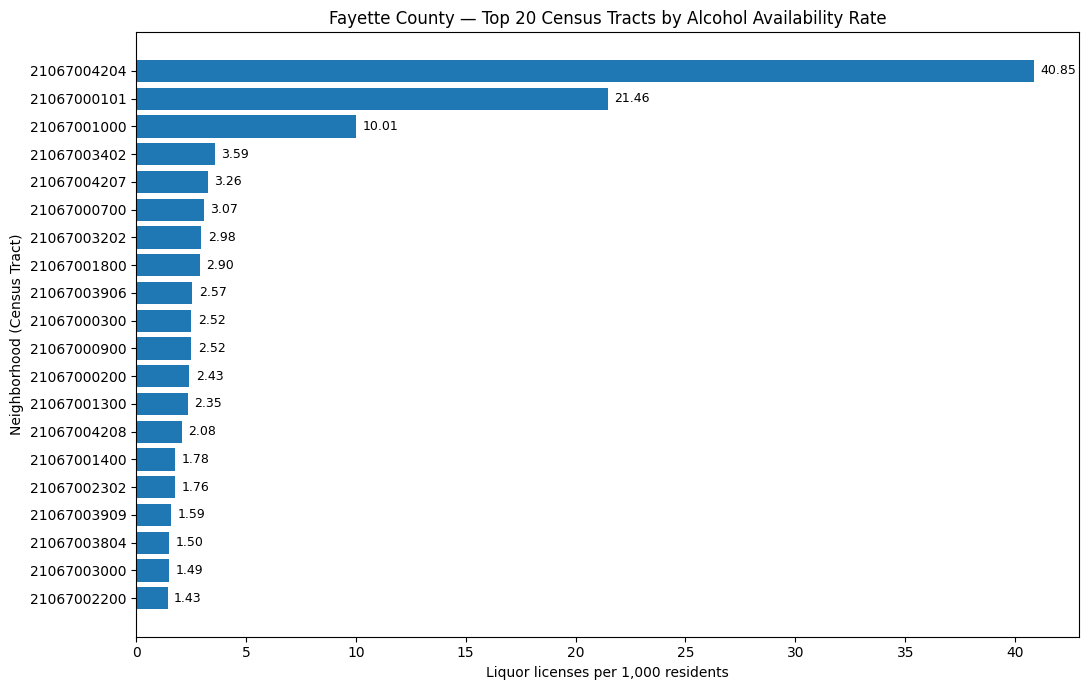

In [ ]:
plt.figure(figsize=(11, 7))

# Use tract IDs as y labels for now
y = top_20_by_rate['tract'].astype(str)
x = top_20_by_rate['LicenseRate']

plt.barh(y, x)
plt.gca().invert_yaxis()  # largest at top
plt.xlabel('Liquor licenses per 1,000 residents')
plt.ylabel('Neighborhood (Census Tract)')
plt.title('Fayette County — Top 20 Census Tracts by Alcohol Availability Rate')

# Add value labels to the right of bars
for i, v in enumerate(x):
    plt.text(v + 0.3, i, f'{v:,.2f}', va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.savefig('top20_by_rate.png', dpi=200)
plt.show()

# B) Top-20 by raw count — horizontal bar chart

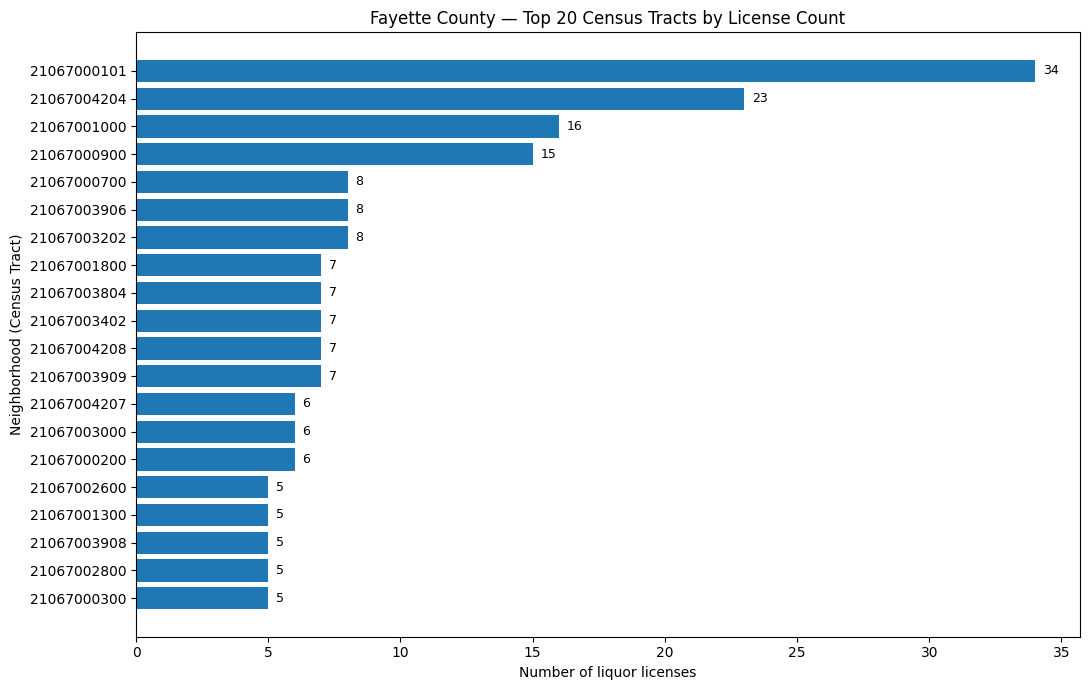

In [ ]:
plt.figure(figsize=(11, 7))

# Use tract IDs as labels
y = top_20_by_count['tract'].astype(str)
x = top_20_by_count['LicenseCount']

plt.barh(y, x)
plt.gca().invert_yaxis()
plt.xlabel('Number of liquor licenses')
plt.ylabel('Neighborhood (Census Tract)')
plt.title('Fayette County — Top 20 Census Tracts by License Count')

# Add value labels to the right of bars
for i, v in enumerate(x):
    plt.text(v + 0.3, i, f'{v:,.0f}', va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.savefig('top20_by_count.png', dpi=200)
plt.show()

# C) Rate vs Count — quick scatter (population context)

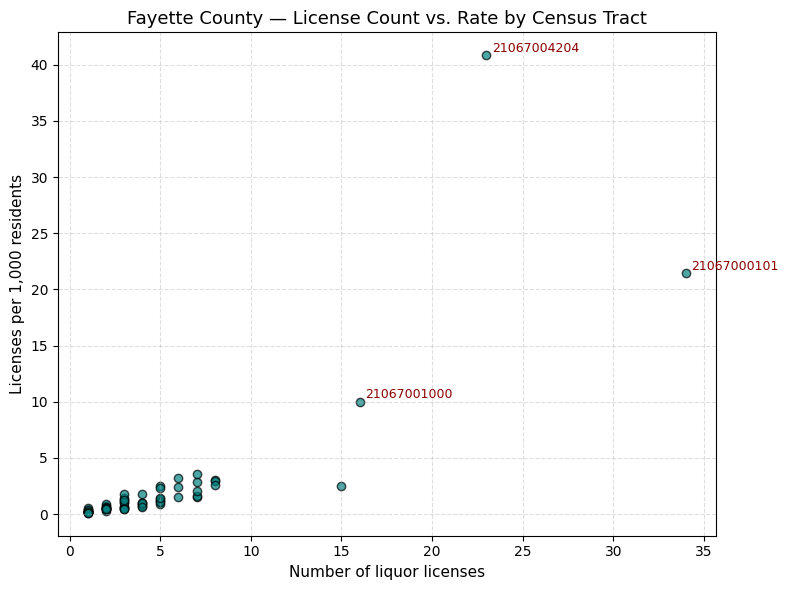

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(clean['LicenseCount'], clean['LicenseRate'], alpha=0.7, color='teal', edgecolor='k')

plt.xlabel('Number of liquor licenses', fontsize=11)
plt.ylabel('Licenses per 1,000 residents', fontsize=11)
plt.title('Fayette County — License Count vs. Rate by Census Tract', fontsize=13)

# Light grid for readability
plt.grid(True, linestyle='--', alpha=0.4)

# Optional: Add a few top points as labels (e.g., top 3 by LicenseRate)
top_points = clean.sort_values(by='LicenseRate', ascending=False).head(3)
for _, row in top_points.iterrows():
    plt.text(row['LicenseCount'] + 0.3,
             row['LicenseRate'] + 0.3,
             str(row['tract']),
             fontsize=9,
             color='darkred')

plt.tight_layout()
plt.savefig('count_vs_rate_scatter.png', dpi=200)
plt.show()

# Part 6 - Discussion
The two lists provide different perspectives on the distribution of licenses across neighborhoods. One emphasizes the intensity of licenses concerning the population, while the other showcases neighborhoods with the highest number of licenses, regardless of population density.
Analyzing both lists provides a more comprehensive understanding of the distribution of licenses within the region, offering insights into both densely licensed areas in relation to population and areas with the most licenses irrespective of population density.